### Funções

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 15 11:26:44 2019

Visualização dos patches ruidosos a partir do grafo k-NN

"""
import sys
import warnings
import time
import skimage
import statistics
import networkx as nx
import matplotlib.pyplot as plt
import skimage.io
import skimage.measure
import numpy as np
import umap
from numpy import eye
import sklearn.neighbors as sknn
from numba import njit   # just in time compiler (acelera loops)

# Para evitar warning de divisão por zero
warnings.simplefilter(action='ignore')

'''
Espelhamento das bordas da imagem A de maneira simétrica
A função pad do numpy não é supertada pelo numba! (para acelerar com jit)
Substitui a função: img_n = np.pad(ruidosa, ((f, f), (f, f)), 'symmetric')
f é o parâmetro (largura das bordas)
'''
@njit
def mirror(A, f):
    n = A.shape[0]
    m = A.shape[1]

    nlin = A.shape[0] + 2*f          # Altura da nova imagem com borda
    ncol = A.shape[1] + 2*f          # Largura da nova imagem com borda
    B = np.zeros((nlin, ncol))      # Inicializa matriz de saída com zeros

    B[f:nlin-f, f:ncol-f] = A       # Copia imagem original no centro

    # Preenche os quatro cantos com reflexão (espelhamento)
    B[0:f, 0:f] = np.flip(A[0:f, 0:f])                          # 1o quadrante
    B[0:f, ncol-f:ncol] = np.flip(A[0:f, m-f:m])                # 2o quadrante
    B[nlin-f:nlin, 0:f] = np.flip(A[n-f:n, 0:f])                # 3o quadrante
    B[nlin-f:nlin, ncol-f:ncol] = np.flip(A[n-f:n, m-f:m])      # 4o quadrante

     # Preenche as bordas (superior, inferior, esquerda, direita)
    B[0:f, f:ncol-f] = np.flipud(A[0:f, :])             # cima
    B[nlin-f:nlin, f:ncol-f] = np.flipud(A[n-f:n, :])   # baixo
    B[f:nlin-f, 0:f] = np.fliplr(A[:, 0:f])             # esquerda
    B[f:nlin-f, ncol-f:ncol] = np.fliplr(A[:, m-f:m])   # direita
    return B

'''
Extrai todos os patches em uma janela local centrada em (i, j)
f: metade do tamanho do patch
t: raio da janela de busca
'''
@njit
def Extract_patches_local(img, i, j, f, t):
    m, n = img.shape                             # Dimensões da imagem
    tamanho_patch = (2*f + 1)*(2*f + 1)          # Tamanho do vetor de um patch

    img_n = mirror(img, f)                       # Adiciona borda espelhada

    im = i + f;                                  # Compensação por causa do padding
    jn = j + f;

    patch_central = img_n[im-f:(im+f)+1, jn-f:(jn+f)+1].copy()      # Patch central
    central = patch_central.reshape((1, patch_central.shape[0]*patch_central.shape[1]))[-1]

    # Limites da janela de busca
    rmin = max(im-t, f)
    rmax = min(im+t, m+f)
    smin = max(jn-t, f)
    smax = min(jn+t, n+f)

    num_elem = (rmax - rmin + 1)*(smax - smin + 1)  # Total de patches na janela

    dataset = np.zeros((num_elem, tamanho_patch))  # Inicializa matriz de patches
    k = 0                                           # Índice do patch atual no dataset

    for r in range(rmin, rmax+1):
        for s in range(smin, smax+1):
            W = img_n[r-f:(r+f)+1, s-f:(s+f)+1].copy()  # Extrai patch da posição atual
            neighbor = W.reshape((1, W.shape[0]*W.shape[1]))[-1]  # Transforma em vetor
            dataset[k, :] = neighbor.copy()              # Adiciona ao dataset

            if (central == neighbor).all():              # Salva índice do patch central
                source = k

            k = k + 1

    return dataset, source   # Retorna todos os patches da janela e o índice do patch central

'''
Constrói o grafo k-NN a partir de uma matriz de dados (n amostras x m features)
'''
def build_KNN_Graph(dados, k):
    KNNG = sknn.kneighbors_graph(dados, n_neighbors=k, mode='distance')  # Grafo de k-vizinhos com pesos = distâncias
    G = nx.from_scipy_sparse_array(KNNG)  # Converte o grafo para formato NetworkX
    return G

def get_umap_embedding(data, n_components=3, random_state=42):
    reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    embedding = reducer.fit_transform(data)
    return embedding

'''
Plota um grafo NetworkX com destaque para um nó central
layout: 'kamada' ou outro (default = spring)
'''
def plota_grafo(G, centro, dimensions=2, layout='spring'):
    n = len(G.nodes)  # Número de nós no grafo

    if dimensions == 3:
        # Para 3D, o layout deve gerar coordenadas 3D
        if layout == 'umap': # UMAP embeddings already provide 3D positions
            pos = nx.get_node_attributes(G, 'pos_3d')
        else:
            # Fallback for other 3D layouts, though UMAP is preferred for this task
            pos = nx.spring_layout(G, dim=3)
            
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Desenha arestas
        for edge in G.edges():
            x = np.array([pos[edge[0]][0], pos[edge[1]][0]])
            y = np.array([pos[edge[0]][1], pos[edge[1]][1]])
            z = np.array([pos[edge[0]][2], pos[edge[1]][2]])
            ax.plot(x, y, z, c='gray', alpha=0.7, linewidth=0.1)

        # Desenha nós
        node_xyz = np.array([pos[v] for v in G.nodes()])
        ax.scatter(node_xyz[:, 0], node_xyz[:, 1], node_xyz[:, 2], s=35, c='black', alpha=0.7)

        # Destaque no centro
        if centro is not None and centro in G.nodes:
            ax.scatter(pos[centro][0], pos[centro][1], pos[centro][2], s=35, c='red', alpha=0.7)

    else:  # 2D plotting
        if layout == 'kamada':
            pos = nx.kamada_kawai_layout(G)  # Layout de Kamada-Kawai
        else:
            pos = nx.spring_layout(G)  # Layout de mola (spring)

        plt.figure(figsize=(12, 8))
        nx.draw_networkx(G, pos, node_size=10, with_labels=False, width=0.1, alpha=0.7)  # Desenha grafo
        if centro is not None and centro in G.nodes:
            nx.draw_networkx_nodes(G, pos, node_size=10, nodelist=[centro], node_color='red', alpha=0.7)  # Destaque no centro

    plt.show()  # Exibe o gráfico
'"""
Espelhamento das bordas da imagem A de maneira simétrica
A função pad do numpy não é supertada pelo numba! (para acelerar com jit)
Substitui a função: img_n = np.pad(ruidosa, ((f, f), (f, f)), 'symmetric')
f é o parâmetro (largura das bordas)
'"""
@njit
def mirror(A, f):
    n = A.shape[0]
    m = A.shape[1]

    nlin = A.shape[0] + 2*f          # Altura da nova imagem com borda
    ncol = A.shape[1] + 2*f          # Largura da nova imagem com borda
    B = np.zeros((nlin, ncol))      # Inicializa matriz de saída com zeros

    B[f:nlin-f, f:ncol-f] = A       # Copia imagem original no centro

    # Preenche os quatro cantos com reflexão (espelhamento)
    B[0:f, 0:f] = np.flip(A[0:f, 0:f])                          # 1o quadrante
    B[0:f, ncol-f:ncol] = np.flip(A[0:f, m-f:m])                # 2o quadrante
    B[nlin-f:nlin, 0:f] = np.flip(A[n-f:n, 0:f])                # 3o quadrante
    B[nlin-f:nlin, ncol-f:ncol] = np.flip(A[n-f:n, m-f:m])      # 4o quadrante

     # Preenche as bordas (superior, inferior, esquerda, direita)
    B[0:f, f:ncol-f] = np.flipud(A[0:f, :])             # cima
    B[nlin-f:nlin, f:ncol-f] = np.flipud(A[n-f:n, :])   # baixo
    B[f:nlin-f, 0:f] = np.fliplr(A[:, 0:f])             # esquerda
    B[f:nlin-f, ncol-f:ncol] = np.fliplr(A[:, m-f:m])   # direita
    return B

'"""
Extrai todos os patches em uma janela local centrada em (i, j)
f: metade do tamanho do patch
t: raio da janela de busca
'"""
@njit
def Extract_patches_local(img, i, j, f, t):
    m, n = img.shape                             # Dimensões da imagem
    tamanho_patch = (2*f + 1)*(2*f + 1)          # Tamanho do vetor de um patch

    img_n = mirror(img, f)                       # Adiciona borda espelhada

    im = i + f;                                  # Compensação por causa do padding
    jn = j + f;

    patch_central = img_n[im-f:(im+f)+1, jn-f:(jn+f)+1].copy()      # Patch central
    central = patch_central.reshape((1, patch_central.shape[0]*patch_central.shape[1]))[-1]

    # Limites da janela de busca
    rmin = max(im-t, f)
    rmax = min(im+t, m+f)
    smin = max(jn-t, f)
    smax = min(jn+t, n+f)

    num_elem = (rmax - rmin + 1)*(smax - smin + 1)  # Total de patches na janela

    dataset = np.zeros((num_elem, tamanho_patch))  # Inicializa matriz de patches
    k = 0                                           # Índice do patch atual no dataset

    for r in range(rmin, rmax+1):
        for s in range(smin, smax+1):
            W = img_n[r-f:(r+f)+1, s-f:(s+f)+1].copy()  # Extrai patch da posição atual
            neighbor = W.reshape((1, W.shape[0]*W.shape[1]))[-1]  # Transforma em vetor
            dataset[k, :] = neighbor.copy()              # Adiciona ao dataset

            if (central == neighbor).all():              # Salva índice do patch central
                source = k

            k = k + 1

    return dataset, source   # Retorna todos os patches da janela e o índice do patch central

'"""
Constrói o grafo k-NN a partir de uma matriz de dados (n amostras x m features)
'"""
def build_KNN_Graph(dados, k):
    KNNG = sknn.kneighbors_graph(dados, n_neighbors=k, mode='distance')  # Grafo de k-vizinhos com pesos = distâncias
    G = nx.from_scipy_sparse_array(KNNG)  # Converte o grafo para formato NetworkX
    return G

def get_umap_embedding(data, n_components=3, random_state=42):
    reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    embedding = reducer.fit_transform(data)
    return embedding

'"""
Plota um grafo NetworkX com destaque para um nó central
layout: 'kamada' ou outro (default = spring)
'"""
def plota_grafo(G, centro, dimensions=2, layout='spring'):
    n = len(G.nodes)  # Número de nós no grafo

    if dimensions == 3:
        # Para 3D, o layout deve gerar coordenadas 3D
        if layout == 'umap': # UMAP embeddings already provide 3D positions
            pos = nx.get_node_attributes(G, 'pos_3d')
        else:
            # Fallback for other 3D layouts, though UMAP is preferred for this task
            pos = nx.spring_layout(G, dim=3)
            
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Desenha arestas
        for edge in G.edges():
            x = np.array([pos[edge[0]][0], pos[edge[1]][0]])
            y = np.array([pos[edge[0]][1], pos[edge[1]][1]])
            z = np.array([pos[edge[0]][2], pos[edge[1]][2]])
            ax.plot(x, y, z, c='gray', alpha=0.7, linewidth=0.1)

        # Desenha nós
        node_xyz = np.array([pos[v] for v in G.nodes()])
        ax.scatter(node_xyz[:, 0], node_xyz[:, 1], node_xyz[:, 2], s=35, c='black', alpha=0.7)

        # Destaque no centro
        if centro is not None and centro in G.nodes:
            ax.scatter(pos[centro][0], pos[centro][1], pos[centro][2], s=35, c='red', alpha=0.7)

    else:  # 2D plotting
        if layout == 'kamada':
            pos = nx.kamada_kawai_layout(G)  # Layout de Kamada-Kawai
        else:
            pos = nx.spring_layout(G)  # Layout de mola (spring)

        plt.figure(figsize=(12, 8))
        nx.draw_networkx(G, pos, node_size=10, with_labels=False, width=0.1, alpha=0.7)  # Desenha grafo
        if centro is not None and centro in G.nodes:
            nx.draw_networkx_nodes(G, pos, node_size=10, nodelist=[centro], node_color='red', alpha=0.7)  # Destaque no centro

    plt.show()  # Exibe o gráfico



### Plots da localização dos centers

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
import random

def pad_imagem_espelhada(imagem, pad=50):
    return np.pad(imagem, ((pad, pad), (pad, pad)), mode='symmetric')


def detectar_n_regioes_sem_sobreposicao(imagem_gray, f=25, limiar_var=20.0, max_regioes=20):
    altura, largura = imagem_gray.shape[0], imagem_gray.shape[1]
    array_centros = []
    usados = np.zeros_like(imagem_gray, dtype=bool)

    candidatos = []

    for i in range(f, altura - f):
        for j in range(f, largura - f):
            patch = imagem_gray[i-f:i+f+1, j-f:j+f+1]
            var = np.var(patch)
            if var >= limiar_var:
                candidatos.append((var, (j, i)))  # (x, y)

    candidatos.sort(reverse=True)  # ordena por variância decrescente

    for _, (x, y) in candidatos:
        if not usados[y-f:y+f+1, x-f:x+f+1].any():
            array_centros.append((x, y))
            usados[y-f:y+f+1, x-f:x+f+1] = True
        if len(array_centros) == max_regioes:
            break

    return array_centros

def exibir_imagem_com_retangulos(img, centers, window_size=(50, 50), raio_circulo=2):
    img_copy = img.copy()
    half_w = window_size[0] // 2
    half_h = window_size[1] // 2

    for (cx, cy) in centers:
        top_left = (cx - half_w, cy - half_h)
        bottom_right = (cx + half_w, cy + half_h)

        # Desenha retângulo verde
        cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)

        # Desenha círculo vermelho no centro
        if 0 <= cy < img_copy.shape[0] and 0 <= cx < img_copy.shape[1]:
            cv2.circle(img_copy, (cx, cy), raio_circulo, (0, 0, 255), -1)  # vermelho preenchido

    # Exibe com matplotlib
    img_rgb = cv2.cvtColor(img_copy.astype(np.uint8), cv2.COLOR_BGR2RGB)

    return img_rgb
 


In [3]:
import os
import numpy as np

def read_directories(directory, img=None, exclude_json=None):
    # Get a list of filenames in the specified directory
    filenames = []
    for filename in os.listdir(directory):
        if img is not None:
            # If 'img' is provided, filter filenames containing it
            if img in filename:   
                filenames.append(filename)
        elif exclude_json is not None:
            filenames.append(filename.replace('.json',''))     
        else:
            filenames.append(filename)    
    return filenames

In [ ]:
from pathlib import Path
from skimage.io import imread
import sys
import time
from skimage.color import rgb2gray


root_dir = "/workspace/ProjetoDoutorado"

# sys.path.insert(0, r"/home/adrianocarvalho/Documentos/ProjetoDoutorado")
# root_dir = Path(r"/home/adrianocarvalho/Documentos/ProjetoDoutorado")



dir_images = f'{root_dir}/images'
dir_out_put = f'{root_dir}/dir_images_out/dir_graphs_out'

array_dir = read_directories(dir_images)

i = 5
for file in array_dir:

    file_name = file
    img = imread(f'{dir_images}/{file_name}', as_gray=False)
   

    # Remove frames extras, se existirem (e.g. GIF com shape (1, H, W) ou (N, H, W, 3))
    if img.ndim == 4:
        img = img[0]
    elif img.ndim == 3 and img.shape[2] != 3:
        img = np.squeeze(img)


    # Checa se imagem é monocromática
    if len(img.shape) > 2:
        img = skimage.color.rgb2gray(img)   # valores convertidos ficam entre 0 e 1
        img = 255*img

    img = img.astype(np.uint8)              # Converte para uint8

    # Clipa imagem para intervalo [0, 255]
    img[np.where(img > 255)] = 255
    img[np.where(img < 0)] = 0

    # Define parâmetros do filtro NLM
    f = 4   # tamanho do patch (2f + 1 x 2f + 1) 5x5
    t = 7  # tamanho da janela de busca (2t + 1 x 2t + 1) 21x21


    # Aplica padding espelhado de 50px
    img_gray_padded = pad_imagem_espelhada(img, pad=50)

    m, n = img_gray_padded.shape

    # Número de vizinhos no grafo k-NN
    nn = 10
    # Aplica padding espelhado de 50px


    # Adiciona ruído
    sigma = 10
    noise = np.random.normal(0, sigma, img_gray_padded.shape)
    noised = np.clip(img_gray_padded.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # Converte para BGR
    noised_bgr = cv2.cvtColor(noised, cv2.COLOR_GRAY2BGR)

    # Detecta 30 regiões sem sobreposição
    thirth_centers = detectar_n_regioes_sem_sobreposicao(noised_bgr, f=25, limiar_var=20.0, max_regioes=30)

    # Sorteia 5 delas
    five_centers = random.sample(thirth_centers, k=20)

    # Desenha as 5 sorteadas
    image = exibir_imagem_com_retangulos(noised_bgr, five_centers, window_size=(50, 50))

    plt.figure(figsize=(16, 12))
    plt.imshow(image)
    # plt.title("5 Regiões com Centro Marcado (vermelho)")
    plt.axis('off')
    img_out_with_rectangle =  f'{dir_out_put}/{file_name}/image_{i}.svg'
    plt.savefig(img_out_with_rectangle, format='svg')
    plt.show()

    # Imprime os centros sorteados
    print("Sorted centers:", five_centers)

    # Remove os patches dentro de cada janela de busca
    for k in range(len(five_centers)):
        # f --> tamanho do patch
        # t --> tamanho da janela de busca  
        patches, patch_center = Extract_patches_local(noised, five_centers[k][0], five_centers[k][1], f, t)
      
        # Constrói grafo KNN
        G = build_KNN_Graph(patches, nn)
        # Plota grafo KNN

        # Define a cor de cada nó: azul por padrão
        colors = ['black'] * G.number_of_nodes()

        # Destaca o nó do centro, se existir
        if patch_center in G.nodes:
            colors[patch_center] = 'red'  # ou outra cor como '#FF0000'

        # Layout (posição dos nós)
        pos = nx.spring_layout(G)


        plt.figure(figsize=(12, 8))
        nx.draw_networkx(G, pos , node_color=colors, node_size=35, with_labels=False, width=0.1, alpha=0.7)  # Desenha grafo
        img_out =  f'{dir_out_put}/{file_name}/graph_{i}_{k+1}.pdf'
        plt.savefig(img_out, format='pdf')
        plt.show()

        # plt.figure(figsize=(12, 8))
        # nx.draw_networkx(G, nx.spring_layout(G) , node_size=10, with_labels=False, width=0.1, alpha=0.7)  # Desenha grafo
        # #nx.draw_networkx_nodes(G, nx.spring_layout(G), node_size=10, nodelist=[centro], node_color='red', alpha=0.7)  # Destaque no centro
        # plt.show()
        #import pdb; pdb.set_trace()
    i+=1
       








In [ ]:
# Define a cor de cada nó: azul por padrão
cores = ['skyblue'] * G.number_of_nodes()

# Destaca o nó 220 (se existir)
if 220 in G.nodes:
    cores[220] = 'red'  # ou outra cor como '#FF0000'

# Layout (posição dos nós)
pos = nx.kamada_kawai_layout(G)


plt.figure(figsize=(16, 12))
nx.draw_networkx(G, pos , node_color=cores, node_size=30, with_labels=True, width=0.1, alpha=0.7)  # Desenha grafo
plt.savefig("grafo.svg", format='svg')
plt.show()


In [ ]:
if 220 in G:
    # 1. Obtem os vizinhos do nó 220
    vizinhos = list(G.neighbors(220))

    # 2. Seleciona até 30 vizinhos (se tiver mais)
    vizinhos_30 = vizinhos[:30]

    # 3. Cria subgrafo com 220 + os 10 vizinhos
    sub_nos = [220] + vizinhos_30
    G_sub = G.subgraph(sub_nos)

    # 4. Desenha o subgrafo
    pos_sub = nx.spring_layout(G_sub)
    cores_sub = ['red' if n == 220 else 'green' for n in G_sub.nodes]

    plt.figure(figsize=(8, 6))
    nx.draw(G_sub, pos_sub, node_color=cores_sub, with_labels=True, node_size=500)
    plt.title("Subgrafo: nó 220 e seus 10 vizinhos")
    plt.show()
else:
    print("O nó 220 não existe no grafo.")

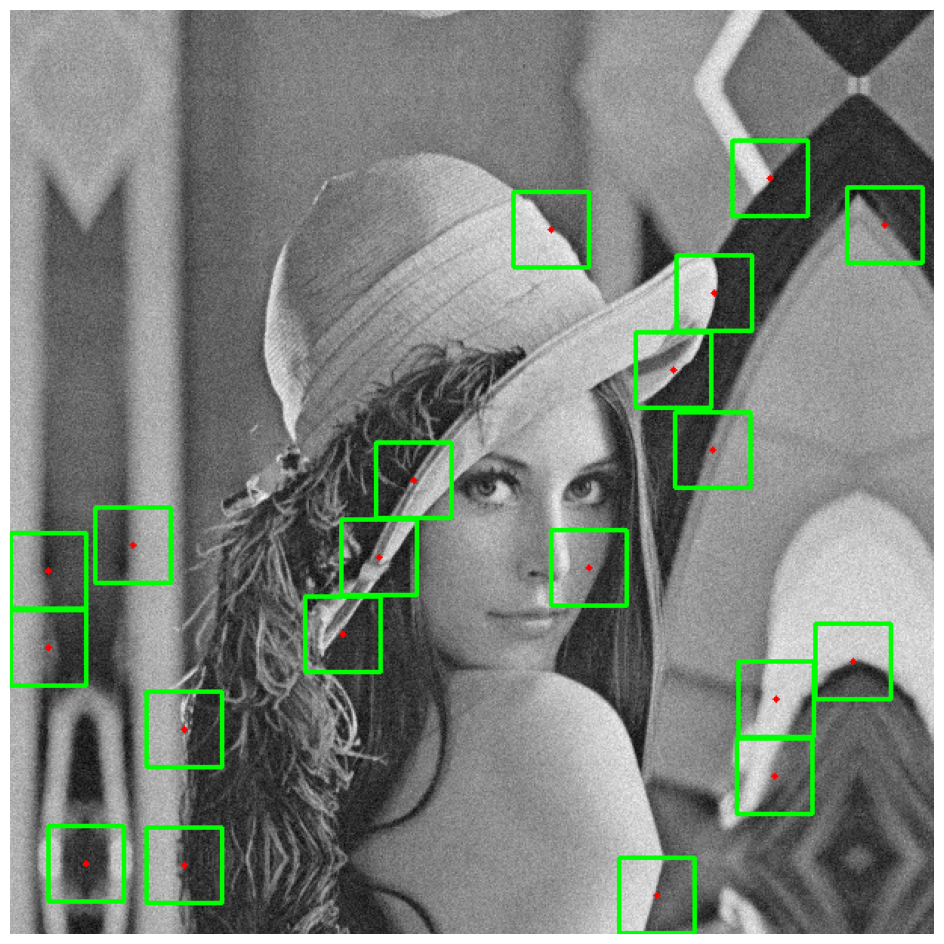

Sorted centers: [(428, 586), (115, 476), (115, 566), (465, 291), (25, 422), (267, 311), (507, 456), (25, 371), (439, 238), (220, 413), (579, 142), (81, 354), (503, 111), (358, 145), (466, 187), (244, 362), (383, 369), (558, 431), (50, 565), (506, 507)]


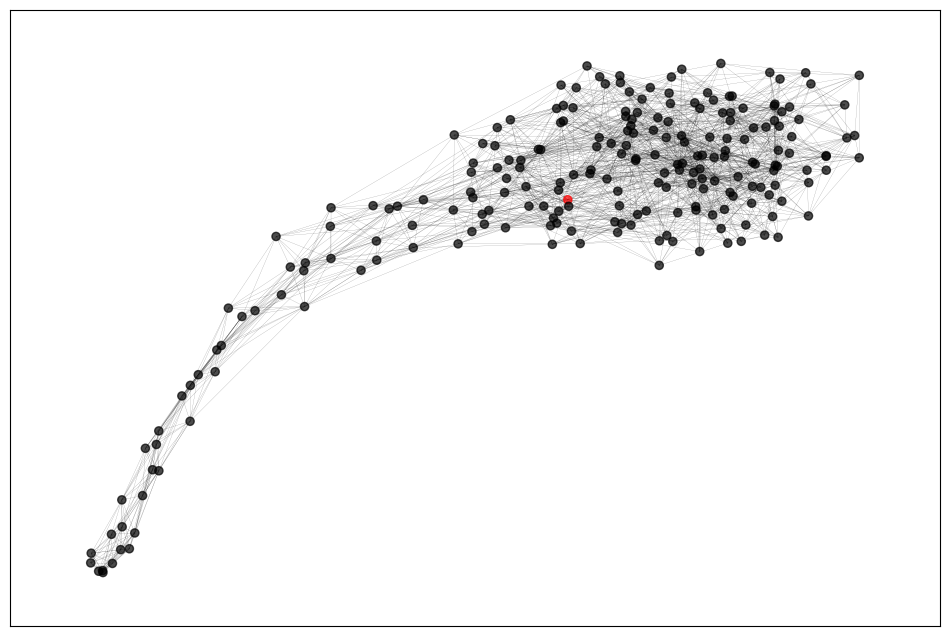

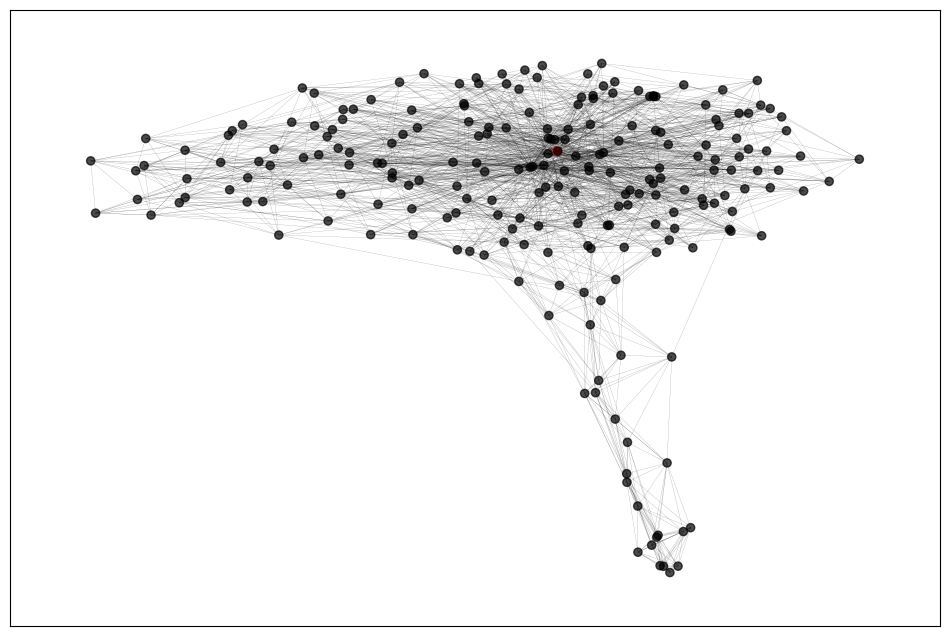

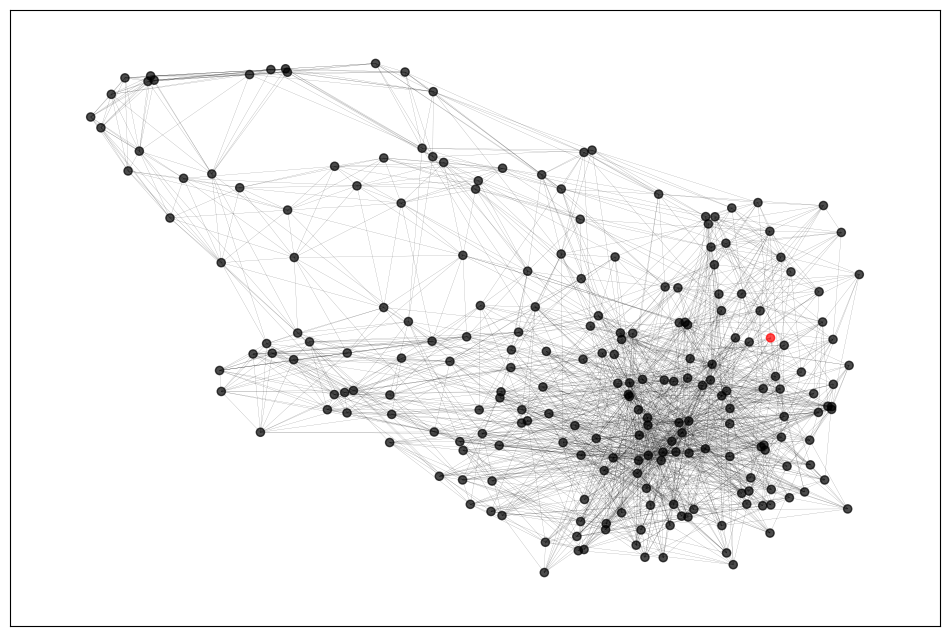

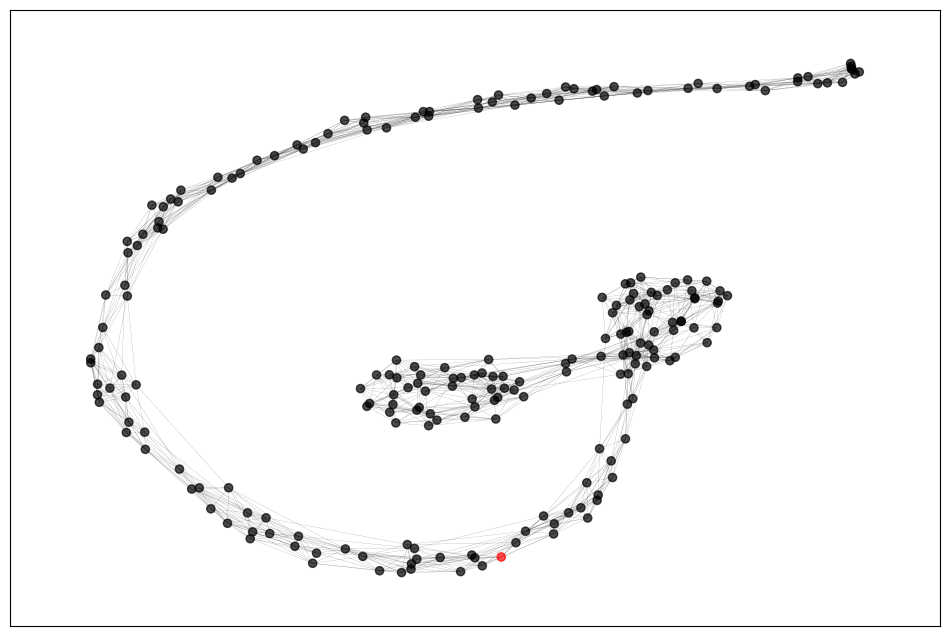

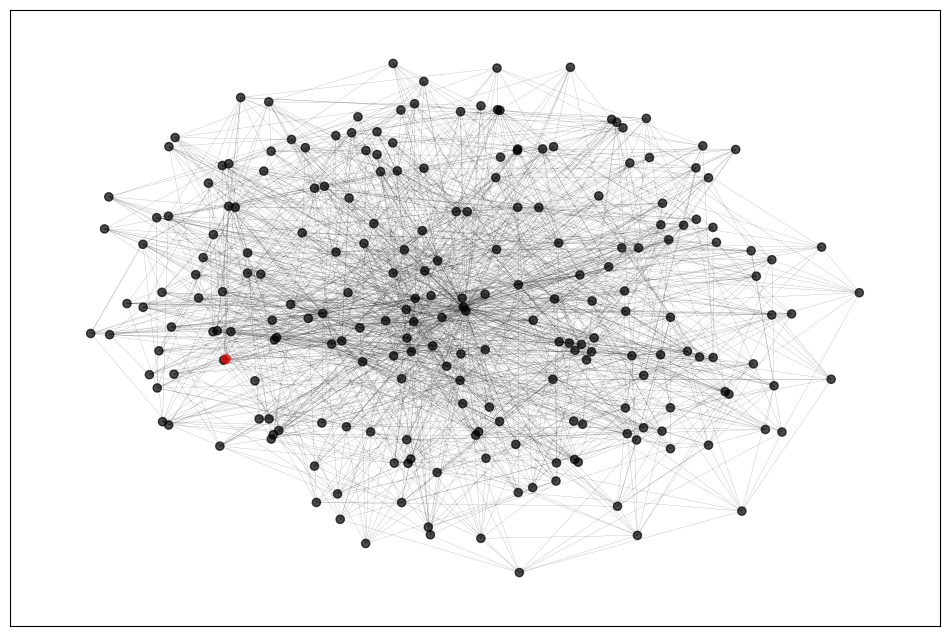

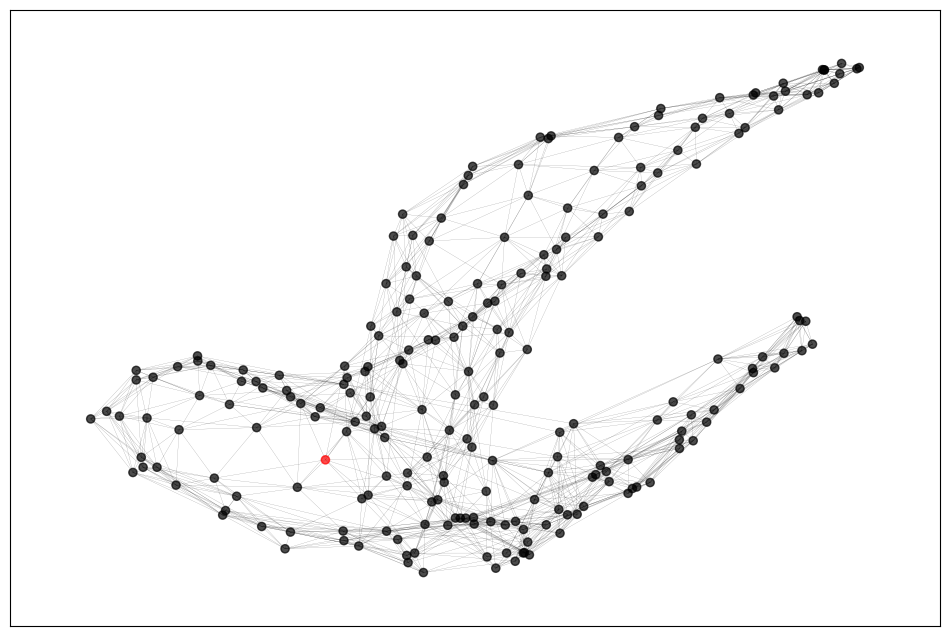

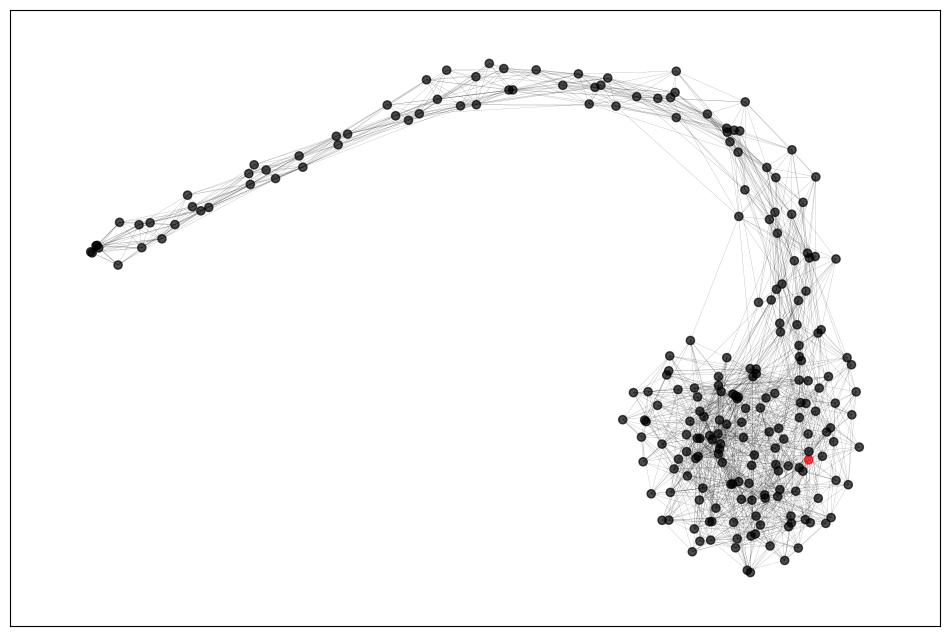

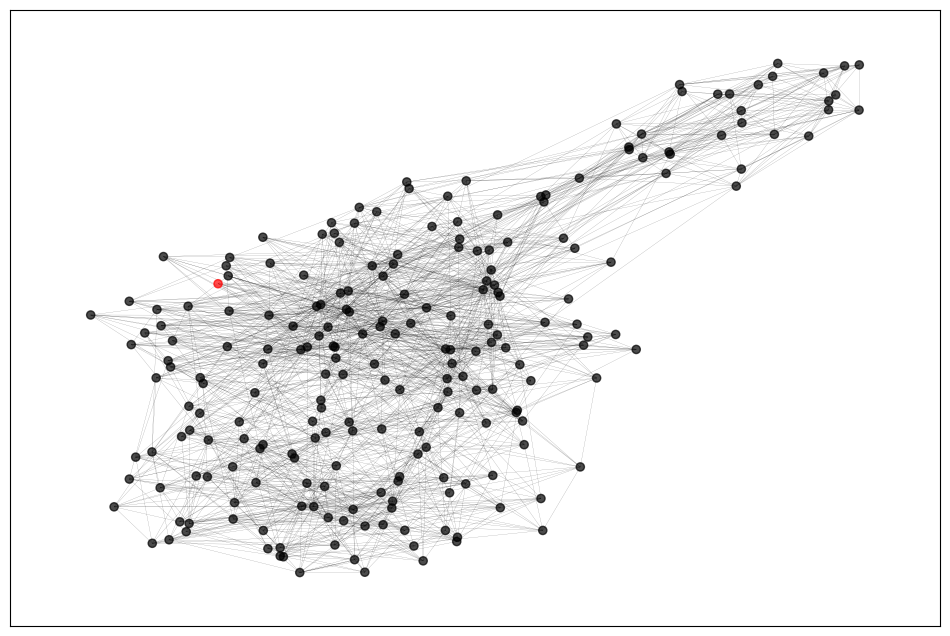

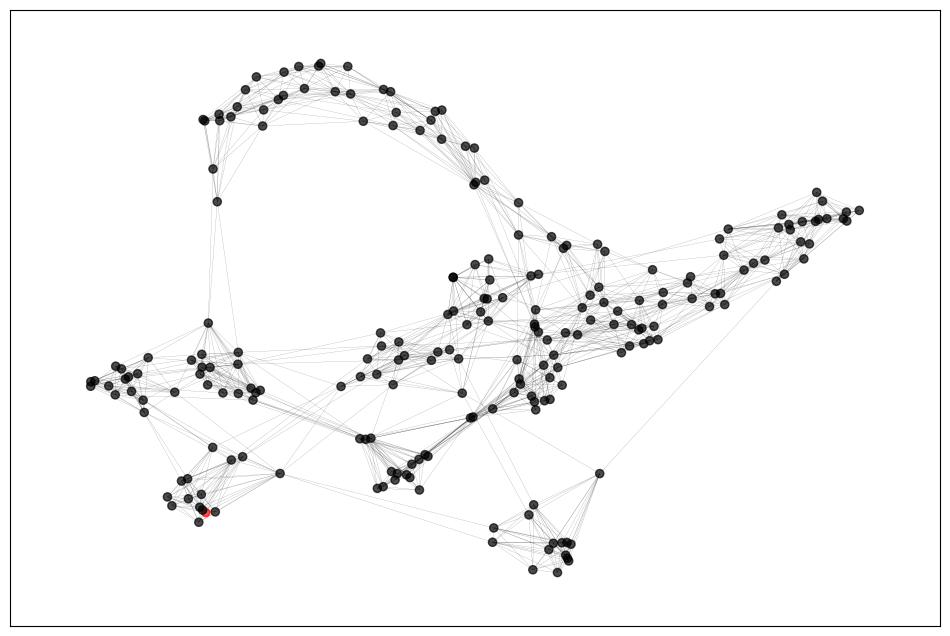

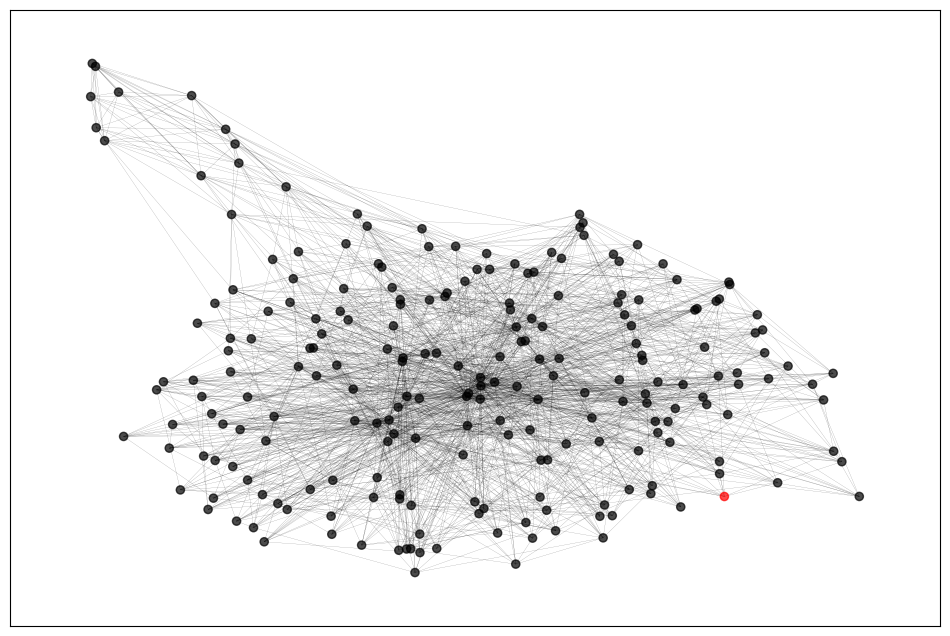

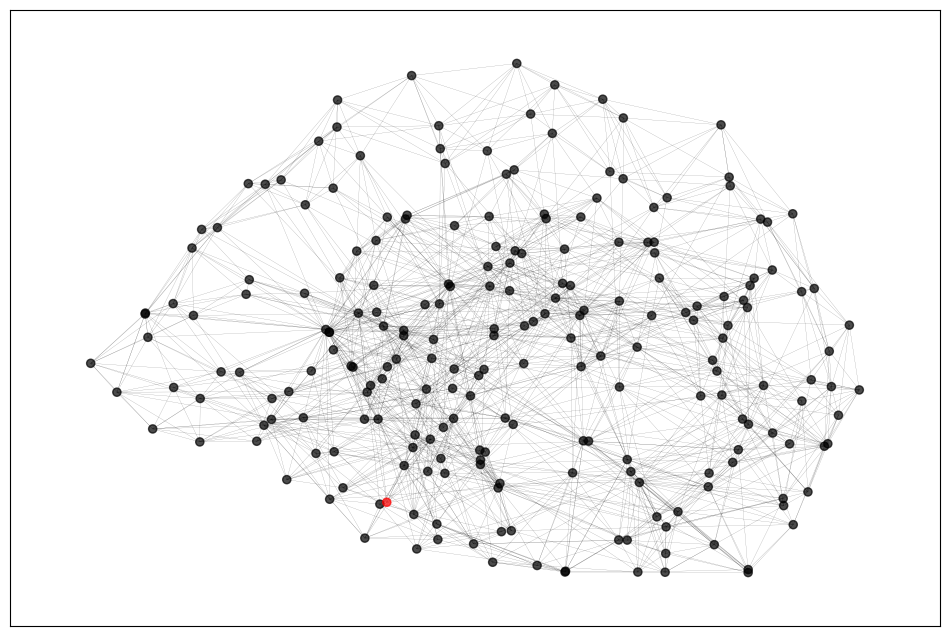

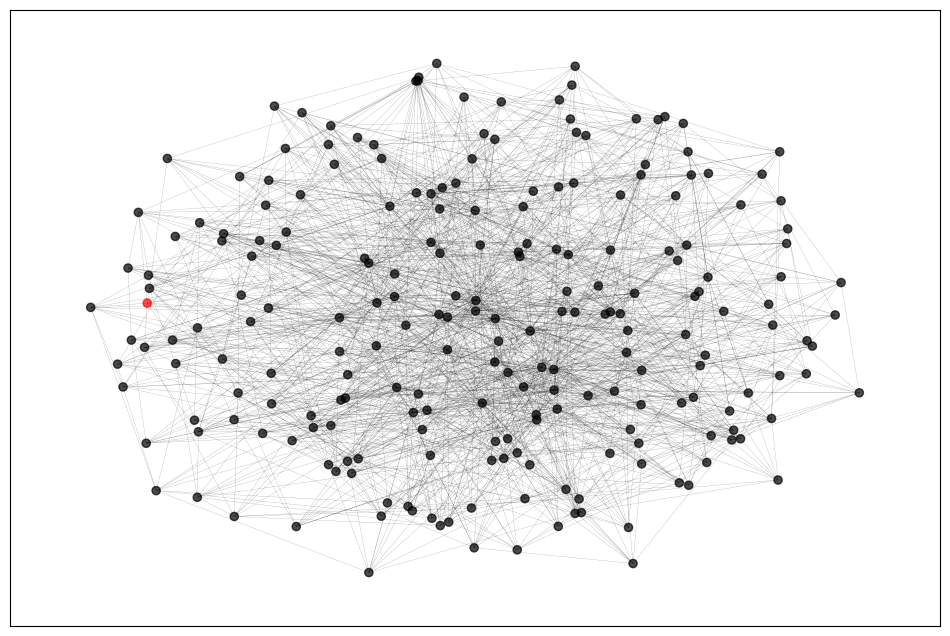

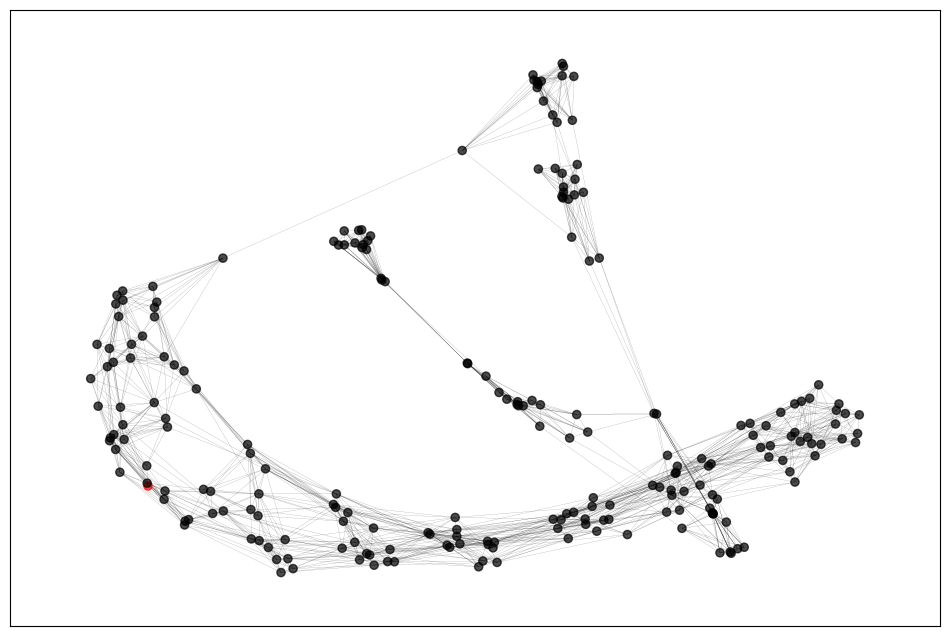

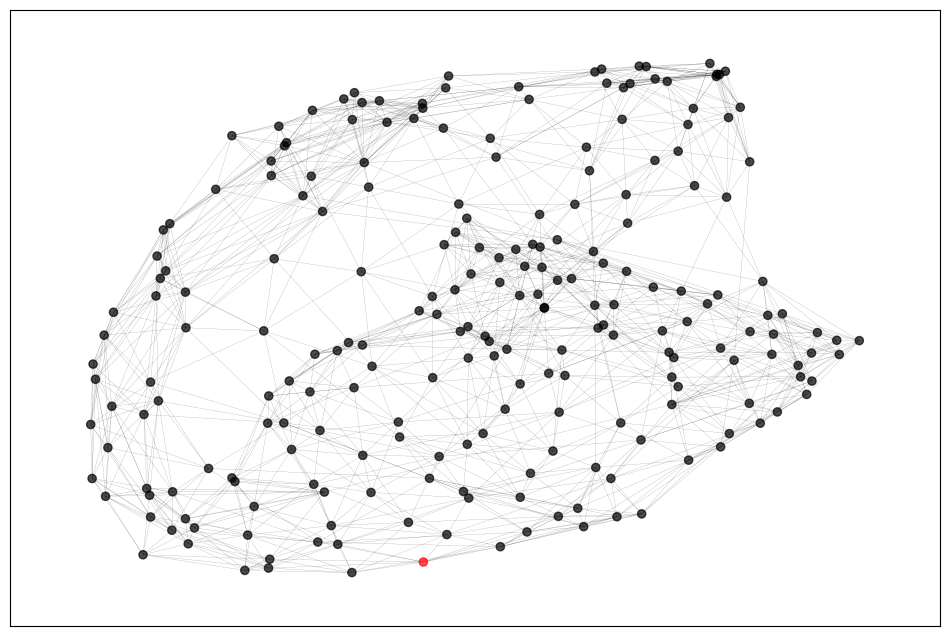

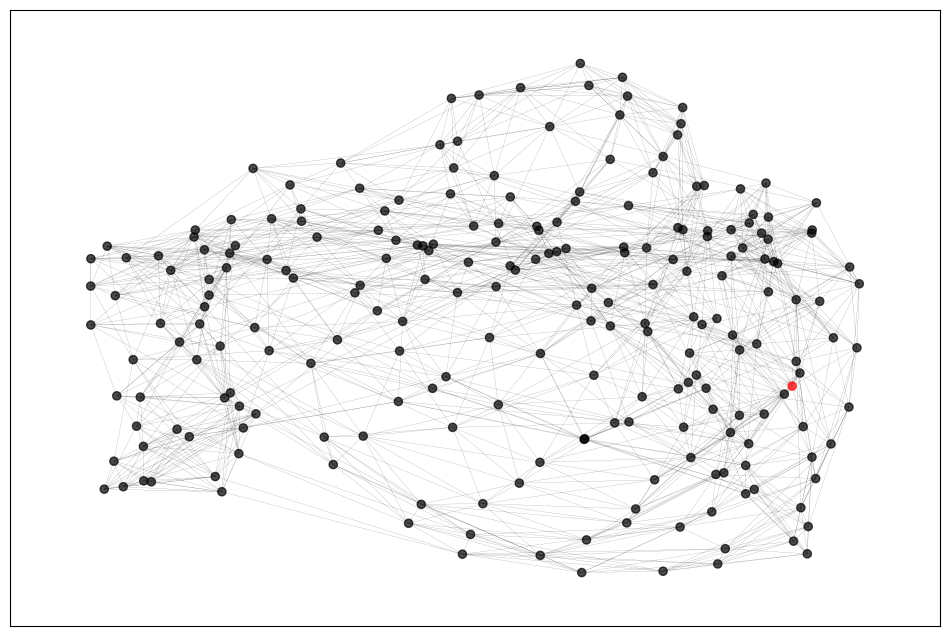

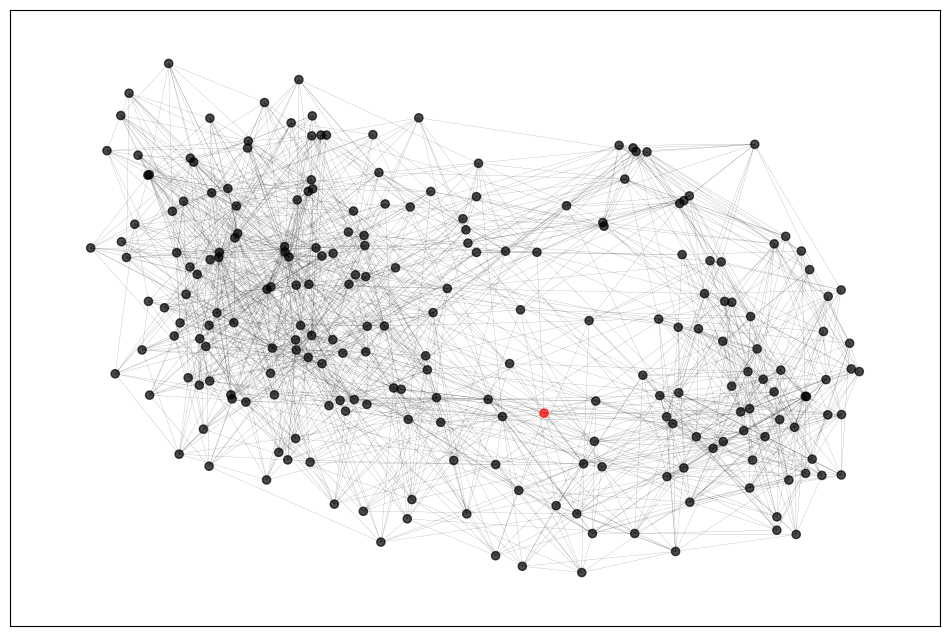

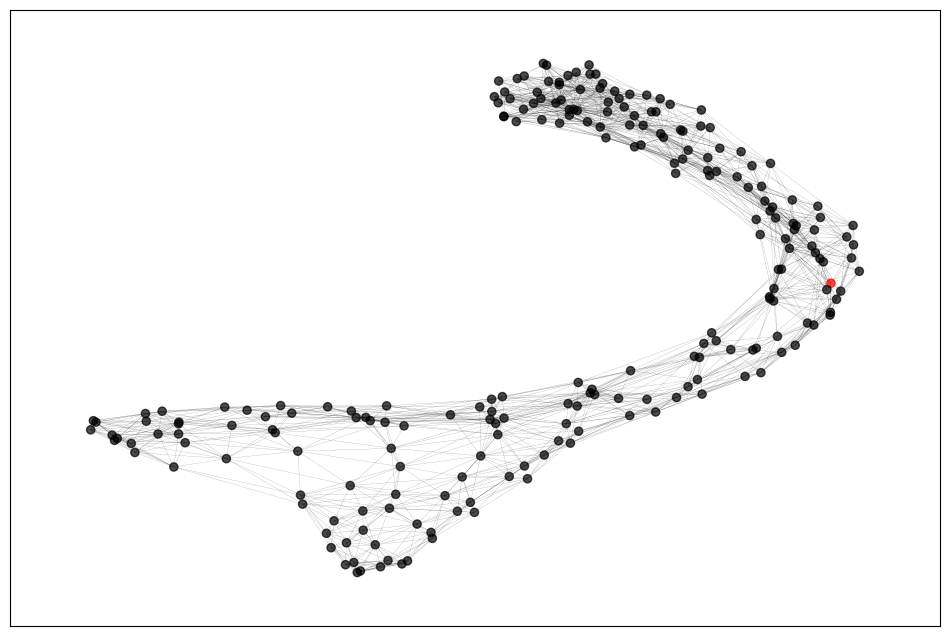

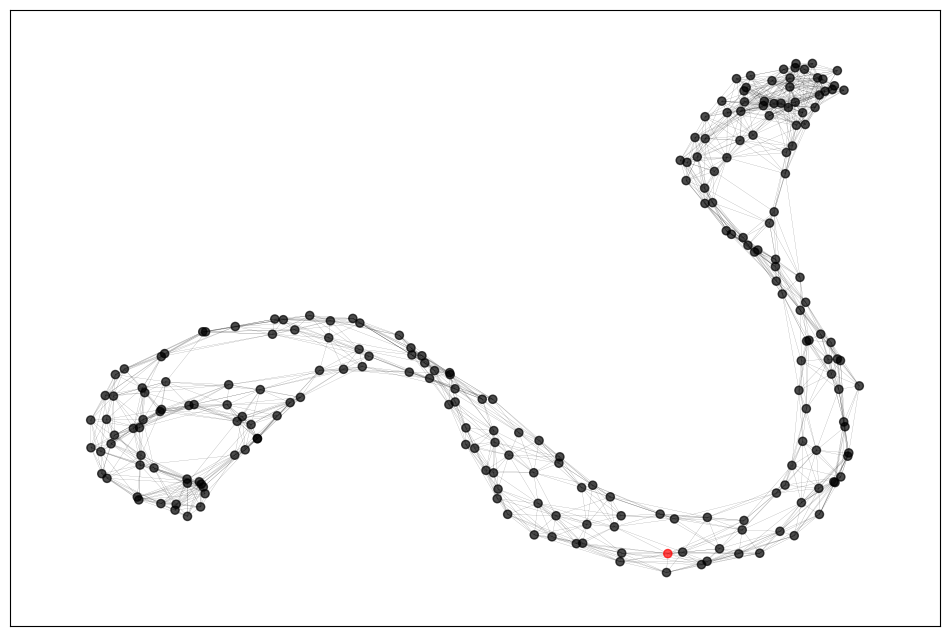

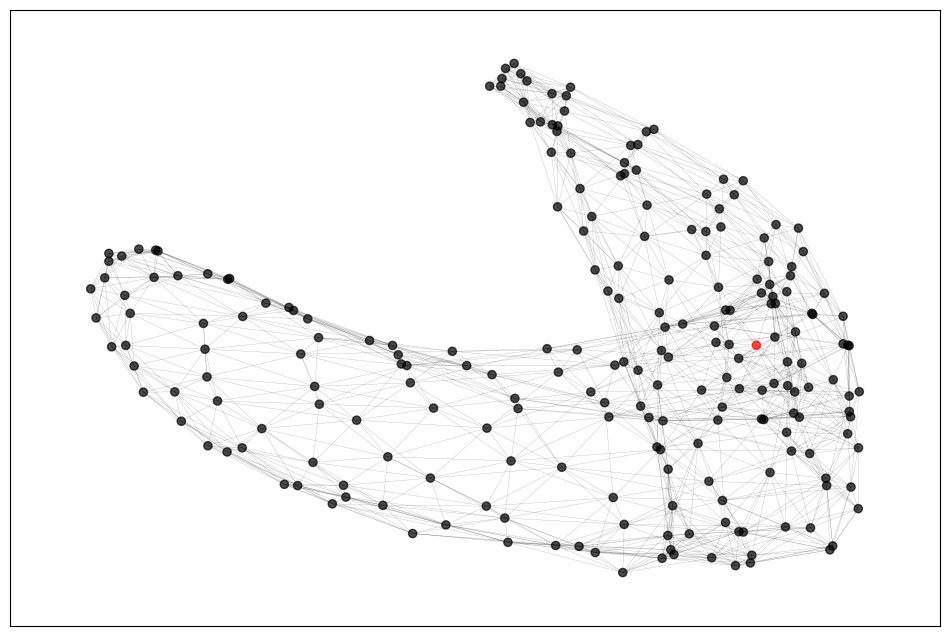

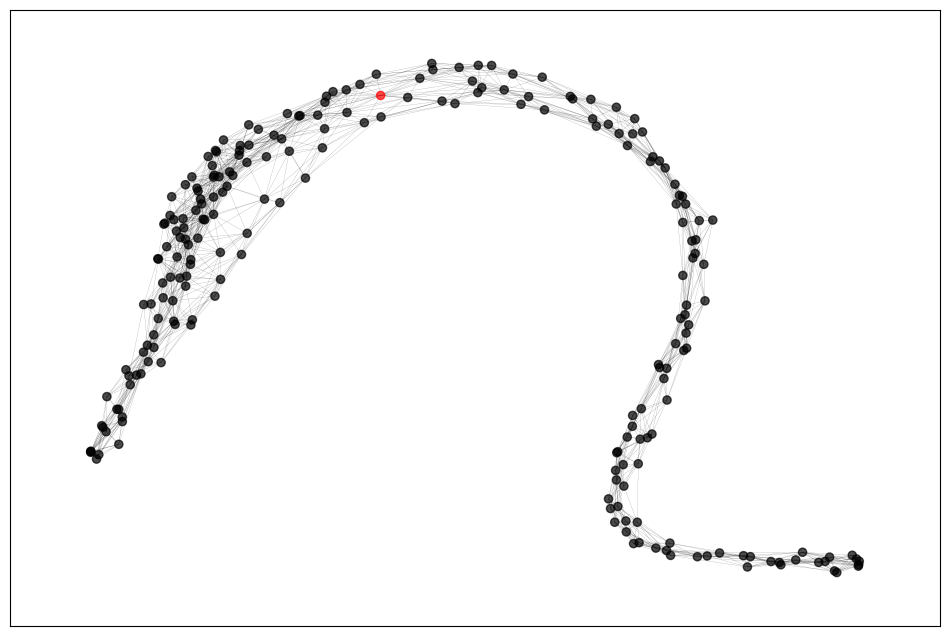

In [7]:
from pathlib import Path
from skimage.io import imread
import sys
import time
from skimage.color import rgb2gray


root_dir = "/workspace/ProjetoDoutorado"

# sys.path.insert(0, r"/home/adrianocarvalho/Documentos/ProjetoDoutorado")
# root_dir = Path(r"/home/adrianocarvalho/Documentos/ProjetoDoutorado")



dir_images = f'{root_dir}/images'
dir_out_put = f'{root_dir}/dir_images_out/dir_graphs_out/0.gif/new'

#array_dir = read_directories(dir_images)


i = 0

img = imread(f'/workspace/ProjetoDoutorado/images/0.gif', as_gray=False)


# Remove frames extras, se existirem (e.g. GIF com shape (1, H, W) ou (N, H, W, 3))
if img.ndim == 4:
    img = img[0]
elif img.ndim == 3 and img.shape[2] != 3:
    img = np.squeeze(img)


# Checa se imagem é monocromática
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)   # valores convertidos ficam entre 0 e 1
    img = 255*img

img = img.astype(np.uint8)              # Converte para uint8

# Clipa imagem para intervalo [0, 255]
img[np.where(img > 255)] = 255
img[np.where(img < 0)] = 0

# Define parâmetros do filtro NLM
f = 4   # tamanho do patch (2f + 1 x 2f + 1) 5x5
t = 7  # tamanho da janela de busca (2t + 1 x 2t + 1) 21x21


# Aplica padding espelhado de 50px
img_gray_padded = pad_imagem_espelhada(img, pad=50)

m, n = img_gray_padded.shape

# Número de vizinhos no grafo k-NN
nn = 10
# Aplica padding espelhado de 50px


# Adiciona ruído
sigma = 10
noise = np.random.normal(0, sigma, img_gray_padded.shape)
noised = np.clip(img_gray_padded.astype(np.float32) + noise, 0, 255).astype(np.uint8)

# Converte para BGR
noised_bgr = cv2.cvtColor(noised, cv2.COLOR_GRAY2BGR)

# Detecta 30 regiões sem sobreposição
view_centers = detectar_n_regioes_sem_sobreposicao(noised_bgr, f=25, limiar_var=20.0, max_regioes=30)

# Sorteia 5 delas
centers = random.sample(view_centers, k=20)

# Desenha as 5 sorteadas
image = exibir_imagem_com_retangulos(noised_bgr, centers, window_size=(50, 50))

plt.figure(figsize=(16, 12))
plt.imshow(image)
# plt.title("5 Regiões com Centro Marcado (vermelho)")
plt.axis('off')
img_out_with_rectangle =  f'{dir_out_put}/0.gif/image_{i}.pdf'
plt.savefig(img_out_with_rectangle, format='pdf')
plt.show()

# Imprime os centros sorteados
print("Sorted centers:", centers)
array_graphs = []

# Remove os patches dentro de cada janela de busca
for k in range(len(centers)):
    # f --> tamanho do patch
    # t --> tamanho da janela de busca  
    patches, patch_center = Extract_patches_local(noised, centers[k][0], centers[k][1], f, t)
    
    # Constrói grafo KNN
    G = build_KNN_Graph(patches, nn)
    # Plota grafo KNN

    # Define a cor de cada nó: azul por padrão
    colors = ['black'] * G.number_of_nodes()

    # Destaca o nó do centro, se existir
    if patch_center in G.nodes:
        colors[patch_center] = 'red'  # ou outra cor como '#FF0000'

    # Layout (posição dos nós)
    pos = nx.spring_layout(G)

    array_graphs.append(G)
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(G, pos , node_color=colors, node_size=35, with_labels=False, width=0.1, alpha=0.7)  # Desenha grafo
    img_out =  f'{dir_out_put}/0.gif/graph_{i}_{k+1}.pdf'
    plt.savefig(img_out, format='pdf')
    plt.show()

    # plt.figure(figsize=(12, 8))
    # nx.draw_networkx(G, nx.spring_layout(G) , node_size=10, with_labels=False, width=0.1, alpha=0.7)  # Desenha grafo
    # #nx.draw_networkx_nodes(G, nx.spring_layout(G), node_size=10, nodelist=[centro], node_color='red', alpha=0.7)  # Destaque no centro
    # plt.show()
    #import pdb; pdb.set_trace()
i+=1

In [8]:
array_graphs